In [604]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LassoCV, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor

sns.set(color_codes=True)

In [11]:
def mse(y_test, y_true):
    return np.mean((y_test - y_true) ** 2)

def expo_fit(y):
    x = np.arange(-y.shape[0], 0)
    return np.exp(np.polyfit(x, np.log(y), 1)[1])

### Step I: Import the data that has already been cleaned and merged

In [6]:
data = pd.read_csv("all_in_1.csv")

X, y = data.drop(columns=['4/18/20']), data['4/18/20']

### Step II: Visualizations (Feel free to skip this part if you want)

In [12]:
results = []
for j in range(86,89):
    result = []
    for i in range(j-12, j-2):
        y_mat = X.iloc[:,i:j].to_numpy()
        exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
        exp_predict[np.isnan(exp_predict)] = 0
        result.append(mse(exp_predict, X.iloc[:,j]))
    results.append(result)

# special handling for interpolating 4/18/20 data
result = []
for i in range(78, 88):
    y_mat = X.iloc[:,i:90].to_numpy()
    exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
    exp_predict[np.isnan(exp_predict)] = 0
    result.append(mse(exp_predict, y))

results.append(result)

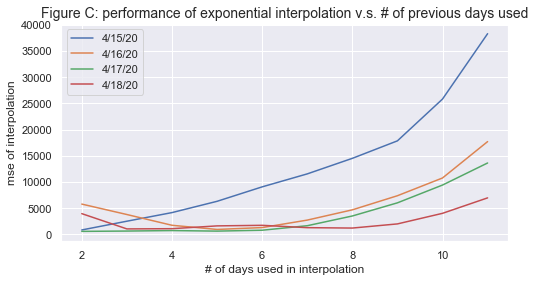

In [537]:
x = np.arange(11, 1, -1)
labels = ['4/15/20', '4/16/20', '4/17/20', '4/18/20']
plt.figure(figsize=(8, 4))
for i in range(4):
    plt.plot(x, results[i], label=labels[i])
plt.legend()
plt.ylabel("mse of interpolation")
plt.xlabel("# of days used in interpolation")
plt.title("Figure C: performance of exponential interpolation v.s. # of previous days used", fontsize=14);

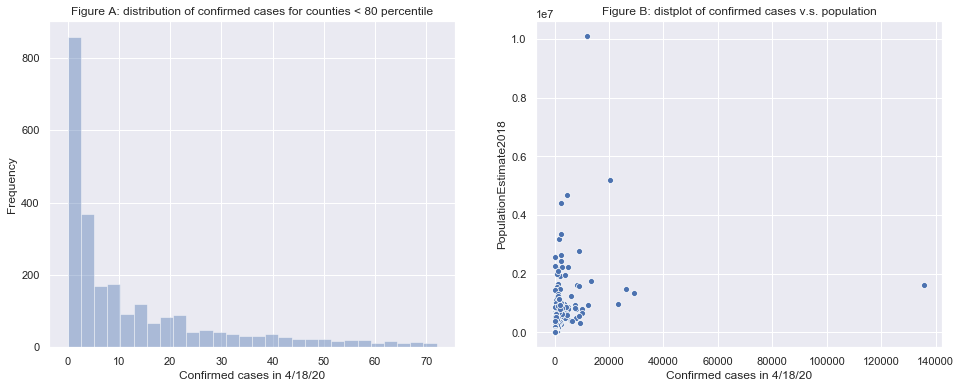

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(y[y < np.percentile(y, 80)], kde=False)
plt.xlabel("Confirmed cases in 4/18/20")
plt.ylabel("Frequency")
plt.title("Figure A: distribution of confirmed cases for counties < 80 percentile");

plt.subplot(1, 2, 2)
sns.scatterplot(x="4/18/20", y="PopulationEstimate2018", data=data)
plt.xlabel("Confirmed cases in 4/18/20")
plt.title("Figure B: distplot of confirmed cases v.s. population");

In [606]:
sfm = SelectFromModel(LassoCV(normalize=True)).fit(X, y)

feature_imp_df = pd.DataFrame({"col_name": X.columns, "imp": sfm.estimator_.coef_})
feature_imp_df.sort_values(by="imp", ascending=False)[:20]

,col_name,imp
5,1/24/20,2.323859e+02
13,2/1/20,2.253467e+02
60,3/19/20,8.781618e-01
111,dem_to_rep_ratio,2.839159e-01
84,4/12/20,2.406786e-01
89,4/17/20,1.788811e-01
87,4/15/20,1.723717e-01
83,4/11/20,1.652801e-01
88,4/16/20,1.527696e-01
85,4/13/20,1.512578e-01


### 3. Simple Regressors (LinearRegression v.s. DecisionTree)

In [553]:
features = ['4/15/20', '4/16/20', '4/17/20', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010', 'MedianAge2010']

features = ['4/15/20',
 '4/16/20',
 '4/17/20',
 'dem_to_rep_ratio',
 'public schools',
 'FracMale2017',
 'DiabetesPercentage',
 'People_Tested',
 'HeartDiseaseMortality',
 ]

X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.1, random_state=42)

Overall MSE of LinearRegressor and TreeRegressor (Regression Tree)

In [572]:
linear_regr = LinearRegression(normalize=True)
linear_regr.fit(X_train, y_train)

tree_regr = DecisionTreeRegressor(max_depth=20, random_state=42)
tree_regr.fit(X_train, y_train)

linear_pred = np.round(np.maximum(0, linear_regr.predict(X_test)))
linear_mse = mse(linear_pred, y_test)
tree_pred = np.round(tree_regr.predict(X_test))
tree_mse = mse(tree_pred, y_test)

linear_mse, tree_mse

(56.02229299363057, 561.0859872611464)

#### Check the mse for prediction of counties with small/middle/large confirmed cases

In [593]:
per_25, per_75 = np.percentile(y_test, 25), np.percentile(y_test, 75)

In [594]:
small_indices = np.argwhere(y_test < per_25).flatten()
middle_indices = np.argwhere((y_test >= per_25) & (y_test < per_75)).flatten()
big_indices = np.argwhere(y_test >= per_75).flatten()

for indices in [small_indices, middle_indices, big_indices]:
    a = y_test.to_numpy()[indices]
    """
    Linear
    """
    b = linear_pred[indices]
    """
    Decision Tree
    """
    c = tree_pred[indices]
    print(f"Linear mse: {mse(a, b)}, Tree mse: {mse(a, c)}")

Linear mse: 5.830985915492958, Tree mse: 0.14084507042253522
Linear mse: 16.00609756097561, Tree mse: 73.70731707317073
Linear mse: 184.20253164556962, Tree mse: 2077.0


In [570]:
class finalRegressor(object):
    def __init__(self, threshold=50, depth=11, forest=False, randstate=42):
        self.thres = threshold
        if forest:
            self.tree_regr = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=randstate)
        else:
            self.tree_regr = DecisionTreeRegressor(max_depth=depth, random_state=randstate)
        self.linear_regr = LinearRegression(normalize=True)
    
    def fit(self, X_train, y_train):
        self.tree_regr.fit(X_train, y_train)
        self.linear_regr.fit(X_train, y_train)
        self.thres_val = np.percentile(y_train, self.thres)
    
    def predict(self, X_test):
        self.linear_pred = np.maximum(self.linear_regr.predict(X_test), 0)
        self.tree_pred = self.tree_regr.predict(X_test)
        self.cond_vec = ((self.linear_pred + self.tree_pred) / 2) < self.thres_val
        return np.round(self.tree_pred * self.cond_vec + self.linear_pred * ~self.cond_vec)


##### Using test data to tune the max_depth for DecisionTree

In [348]:
depth_results = []
small_indices = np.argwhere(y_test < 100).flatten()

for depth in range(3, 30):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    a, b = dt.predict(X_test)[small_indices], y_test.to_numpy()[small_indices]
    depth_results.append(mse(a, b))

In [601]:
optimal_max_depth = np.argmin(depth_results) + 3
optimal_max_depth

11

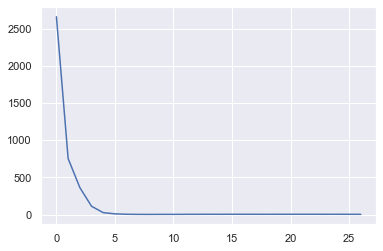

In [350]:
plt.plot(depth_results)

##### Using 5-fold CV to tune the best threshold of our final predictor

In [597]:
kf = KFold(n_splits=5)
best_thres, best_val = None, float('inf')

for thres in range(20, 100):
    cv_result = []
    for train_index, test_index in kf.split(X_train):
        final_regr = finalRegressor(thres)
        final_regr.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        final_pred = final_regr.predict(X_train.iloc[test_index])
        cv_result.append(mse(final_pred, y_train.iloc[test_index]))
    if best_val > np.mean(cv_result):
        best_val = np.mean(cv_result)
        best_thres = thres

Final predictor

In [571]:
final_predictor = finalRegressor(best_thres) 
final_predictor.fit(X_train, y_train)
mse(y_test, final_predictor.predict(X_test))

48.5796178343949

#### Below are tricks that should be hidden from our submission (automatic subset selection cheat)

In [402]:
base_features = ['4/15/20', '4/16/20', '4/17/20', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010', 'MedianAge2010'] 

all_features = list(set(X.columns[90:]) - set(base_features))

X_train, X_test, y_train, y_test = train_test_split(X[base_features], y, test_size=0.1, random_state=42)

cheat_regr = LinearRegression(normalize=True)
cheat_regr.fit(X_train, y_train)
cheat_pred = np.round(np.maximum(0, cheat_regr.predict(X_test)))
cheat_mse = mse(cheat_pred, y_test)

sota_feature = base_features
sota_mse = cheat_mse

u, v, c = 0, len(all_features), 0
while u < v:
    c += 1
    temp_features = sota_feature + [all_features[u]]
    X_train, X_test, y_train, y_test = train_test_split(X[temp_features], y, test_size=0.1, random_state=42)
    cheat_regr = LinearRegression(normalize=True)
    cheat_regr.fit(X_train, y_train)
    cheat_pred = np.round(np.maximum(0, cheat_regr.predict(X_test)))
    cheat_mse = mse(cheat_pred, y_test)
    if cheat_mse < sota_mse:
        all_features.remove(all_features[u])
        sota_feature = temp_features
        sota_mse = cheat_mse
        u = 0
        v -= 1
    else:
        u += 1